In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_out= dir_ssp_modeling.joinpath("ssp_run/bau_energy")
# dir_out= dir_ssp_modeling.joinpath("ssp_run/bau")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
dir_scenario_mapping

PosixPath('/home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/scenario_mapping')

In [5]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [6]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "bau_energy_config.yaml")
config_params = g_utils.read_yaml(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  uganda
SSP input file name:  ssp_inputs_uganda_BaU_Scenario.csv
SSP transformation CW:  ssp_uganda_transformation_cw_bau.xlsx
Energy model flag:  True
Set lndu reallocation factor to zero flag:  True


In [7]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [9]:
df_inputs_raw = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw)

In [10]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,frac_lvst_mm_sheep_anaerobic_lagoon,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,ef_lndu_conv_other_to_forests_mangroves_gg_co2_ha,pij_lndu_other_to_forests_mangroves,frac_lvst_mm_cattle_nondairy_dry_lot,frac_lvst_mm_buffalo_paddock_pasture_range,pij_lndu_settlements_to_settlements,frac_lvst_mm_pigs_anaerobic_lagoon,frac_agrc_nuts_cl1_temperate,pij_lndu_forests_primary_to_forests_mangroves,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [11]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [12]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

# frac_lndu_initial modification

In [13]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]


frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.191637
frac_lndu_initial_forests_primary      0.088106
frac_lndu_initial_settlements          0.002294
frac_lndu_initial_forests_secondary    0.017221
frac_lndu_initial_other                0.019260
frac_lndu_initial_grasslands           0.219108
frac_lndu_initial_croplands            0.462375
Name: 0, dtype: float64

In [14]:
james = pd.read_csv(os.path.join(dir_data, "ssp_inputs_uganda_asp_scenario_with_dijis_inputs_and_adj_qmats.csv"))

In [15]:
df_inputs_raw_complete["frac_lndu_initial_forests_primary"] = james["frac_lndu_initial_forests_primary"] 
df_inputs_raw_complete["frac_lndu_initial_forests_secondary"] = james["frac_lndu_initial_forests_secondary"]
df_inputs_raw_complete['frac_lndu_initial_forests_mangroves'] = james['frac_lndu_initial_forests_mangroves']
df_inputs_raw_complete['frac_lndu_initial_grasslands'] = james['frac_lndu_initial_grasslands']
df_inputs_raw_complete['frac_lndu_initial_settlements'] = james['frac_lndu_initial_settlements'] 
df_inputs_raw_complete['frac_lndu_initial_wetlands'] = james['frac_lndu_initial_wetlands']
df_inputs_raw_complete['frac_lndu_initial_croplands'] = james['frac_lndu_initial_croplands']
df_inputs_raw_complete['frac_lndu_initial_other'] = james['frac_lndu_initial_other']

In [16]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]

frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.043018
frac_lndu_initial_forests_primary      0.025318
frac_lndu_initial_settlements          0.009043
frac_lndu_initial_forests_secondary    0.129856
frac_lndu_initial_other                0.000548
frac_lndu_initial_grasslands           0.266578
frac_lndu_initial_croplands            0.525639
Name: 0, dtype: float64

# Transicion Matrix

In [17]:
pij_ex =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_" in i]].columns
pij_ex

Index(['pij_lndu_croplands_to_croplands',
       'pij_lndu_croplands_to_forests_mangroves',
       'pij_lndu_croplands_to_forests_primary',
       'pij_lndu_croplands_to_forests_secondary',
       'pij_lndu_croplands_to_grasslands', 'pij_lndu_croplands_to_other',
       'pij_lndu_croplands_to_settlements', 'pij_lndu_croplands_to_wetlands',
       'pij_lndu_forests_mangroves_to_croplands',
       'pij_lndu_forests_mangroves_to_forests_mangroves',
       'pij_lndu_forests_mangroves_to_forests_primary',
       'pij_lndu_forests_mangroves_to_forests_secondary',
       'pij_lndu_forests_mangroves_to_grasslands',
       'pij_lndu_forests_mangroves_to_other',
       'pij_lndu_forests_mangroves_to_settlements',
       'pij_lndu_forests_mangroves_to_wetlands',
       'pij_lndu_forests_primary_to_croplands',
       'pij_lndu_forests_primary_to_forests_mangroves',
       'pij_lndu_forests_primary_to_forests_primary',
       'pij_lndu_forests_primary_to_forests_secondary',
       'pij_lndu_forests

In [18]:
pij_lndu_croplands =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_lndu_croplands_to" in i]].columns
df_inputs_raw_complete[pij_lndu_croplands].tail()

,pij_lndu_croplands_to_croplands,pij_lndu_croplands_to_forests_mangroves,pij_lndu_croplands_to_forests_primary,pij_lndu_croplands_to_forests_secondary,pij_lndu_croplands_to_grasslands,pij_lndu_croplands_to_other,pij_lndu_croplands_to_settlements,pij_lndu_croplands_to_wetlands
31,0.995995,0,0,0.000007,0,0,0,0.003998
32,0.995995,0,0,0.000007,0,0,0,0.003998
33,0.995995,0,0,0.000007,0,0,0,0.003998
34,0.995995,0,0,0.000007,0,0,0,0.003998
35,0.995995,0,0,0.000007,0,0,0,0.003998


In [19]:
df_inputs_raw_complete[pij_ex] = james[pij_ex]

In [20]:
df_inputs_raw_complete[pij_lndu_croplands].tail()

,pij_lndu_croplands_to_croplands,pij_lndu_croplands_to_forests_mangroves,pij_lndu_croplands_to_forests_primary,pij_lndu_croplands_to_forests_secondary,pij_lndu_croplands_to_grasslands,pij_lndu_croplands_to_other,pij_lndu_croplands_to_settlements,pij_lndu_croplands_to_wetlands
31,0.999656,0,0,0.000344,0,0,0,0.0
32,0.999746,0,0,0.000254,0,0,0,0.0
33,0.999828,0,0,0.000172,0,0,0,0.0
34,0.999894,0,0,0.000106,0,0,0,0.0
35,0.999894,0,0,0.000106,0,0,0,0.0


In [21]:
pop_lvst_initial =  df_inputs_example[[i for i in df_inputs_example.columns if "pop_lvst_initial" in i]].columns
pop_lvst_initial 


Index(['pop_lvst_initial_buffalo', 'pop_lvst_initial_cattle_dairy',
       'pop_lvst_initial_cattle_nondairy', 'pop_lvst_initial_chickens',
       'pop_lvst_initial_goats', 'pop_lvst_initial_horses',
       'pop_lvst_initial_mules', 'pop_lvst_initial_pigs',
       'pop_lvst_initial_sheep'],
      dtype='object')

In [22]:

# implement models -> import sispeuede.manager.sisepuede_models as sm
import sisepuede.manager.sisepuede_models as sm

models = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = False,
)

##  DO THE ADJUSTMENTS HERE TO BASELINE INPUTS FILE

df_inputs = df_inputs_raw_complete.copy()

modvar_agrc_yf = matt.get_variable(models.model_afolu.modvar_agrc_yf)
modvar_lndu_area = matt.get_variable(models.model_afolu.modvar_lndu_area_by_cat)
modvar_lndu_frac_pasture = matt.get_variable(models.model_afolu.modvar_lndu_frac_grassland_that_is_pasture)
modvar_lvst_cc_scalar = matt.get_variable(models.model_afolu.modvar_lvst_carrying_capacity_scalar, )
modvar_lvst_demand = matt.get_variable(models.model_afolu.modvar_lvst_demand_livestock, )
modvar_lvst_pop = matt.get_variable(models.model_afolu.modvar_lvst_pop, )

In [23]:
df_inputs["elasticity_ippu_wood_production_to_gdp"].head()

0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
Name: elasticity_ippu_wood_production_to_gdp, dtype: float64

In [24]:
df_inputs["elasticity_ippu_wood_production_to_gdp"] = 0

In [25]:
df_inputs["elasticity_ippu_wood_production_to_gdp"].head()

0    0
1    0
2    0
3    0
4    0
Name: elasticity_ippu_wood_production_to_gdp, dtype: int64

In [26]:
##  UPDATE CARRYING CAPACITY

array_scale = matt.extract_model_variable(
    df_inputs_raw_complete,
    modvar_lvst_cc_scalar,
    override_vector_for_single_mv_q = True,
    return_type = "array_base",
)

vec_scale_capacity = sf.ramp_vector(
    df_inputs_raw_complete.shape[0],
    r_0 = 10,
)*0.5 + 1

df_inputs[modvar_lvst_cc_scalar.fields] = sf.do_array_mult(
    array_scale,
    vec_scale_capacity
)

In [27]:
##  UPDATE PASTURE FRACTION

array_frac_pasture = matt.extract_model_variable(
    df_inputs_raw_complete,
    modvar_lndu_frac_pasture,
    override_vector_for_single_mv_q = True,
    return_type = "array_base",
)

vec_adjust_pasture = sf.ramp_vector(
    df_inputs_raw_complete.shape[0],
    r_0 = 5,
)*(6.439197e+06/4.014804e+06 - 1) + 1 # est values of grassland at time 0 and 35

df_inputs[modvar_lndu_frac_pasture.fields] = sf.do_array_mult(
    array_frac_pasture,
    vec_adjust_pasture
)

df_out = models.project(df_inputs, )


In [28]:
# you can add the new gdp to df_inputs_high_gdp
df_inputs_raw_complete = df_inputs

In [29]:
pij_lndu_forests_primary =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_lndu_forests_primary_to" in i]].columns
df_inputs_raw_complete[pij_lndu_forests_primary].tail()

,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_primary_to_forests_mangroves,pij_lndu_forests_primary_to_forests_primary,pij_lndu_forests_primary_to_forests_secondary,pij_lndu_forests_primary_to_grasslands,pij_lndu_forests_primary_to_other,pij_lndu_forests_primary_to_settlements,pij_lndu_forests_primary_to_wetlands
31,0.013984,0,0.985625,0,0.000005,0.000356,0,0.000031
32,0.013983,0,0.985601,0,0.000005,0.000377,0,0.000033
33,0.013981,0,0.985596,0,0.000005,0.000385,0,0.000033
34,0.013981,0,0.985564,0,0.000006,0.000411,0,0.000038
35,0.013981,0,0.985564,0,0.000006,0.000411,0,0.000038


<Axes: >

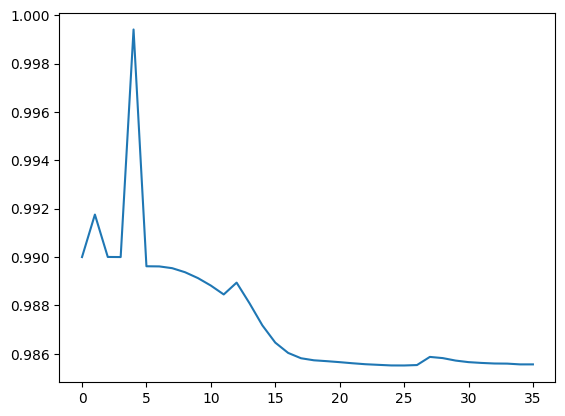

In [30]:
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_primary'].plot()

<Axes: >

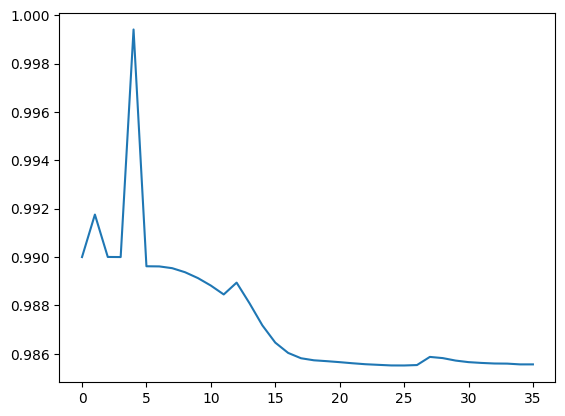

In [31]:
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_primary'].plot()

<Axes: >

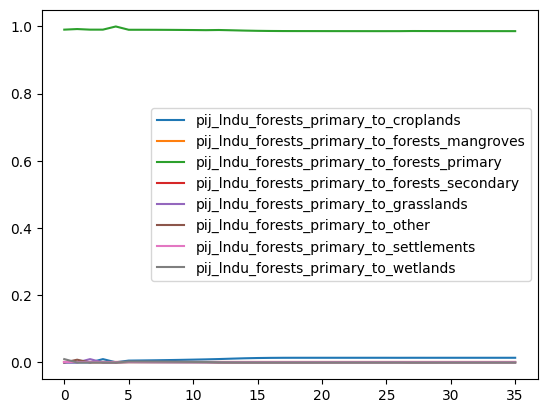

In [32]:
df_inputs_raw_complete[pij_lndu_forests_primary].plot()

## Let's Modify the  LNDU Reallocation factor

In [33]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

In [34]:
# Número de pasos entre time_period 20 y 35 (inclusive)
start, end = 10, 35
n_steps = end - start + 1

# Generar la serie progresiva lineal de 0 a 0.02
series = np.linspace(0, 0.0026666, n_steps)

# Asignar los valores a la columna lndu_reallocation_factor para los time_period deseados
df_inputs_raw_complete.loc[
    df_inputs_raw_complete["time_period"].between(start, end), 
    "lndu_reallocation_factor"
] = series

In [35]:
df_inputs_raw_complete[['time_period','lndu_reallocation_factor']].tail(10)

,time_period,lndu_reallocation_factor
26,26,0.001707
27,27,0.001813
28,28,0.001920
29,29,0.002027
30,30,0.002133
31,31,0.002240
32,32,0.002347
33,33,0.002453
34,34,0.002560
35,35,0.002667


## Evolution gdp_mmm_usd BaU Scenario

In [36]:
df_inputs_raw_complete['gdp_mmm_usd'].tail()

31    443.314127
32    483.212399
33    526.701514
34    574.104651
35    625.774069
Name: gdp_mmm_usd, dtype: float64

In [37]:
df_inputs_raw_complete = df_inputs_raw_complete.sort_values("time_period")
df_inputs_raw_complete["gdp_mmm_usd_pct_change"] = df_inputs_raw_complete["gdp_mmm_usd"].pct_change() * 100

In [38]:
df_inputs_raw_complete[['time_period','gdp_mmm_usd','gdp_mmm_usd_pct_change']].tail()

,time_period,gdp_mmm_usd,gdp_mmm_usd_pct_change
31,31,443.314127,9.0
32,32,483.212399,9.0
33,33,526.701514,9.0
34,34,574.104651,9.0
35,35,625.774069,9.0


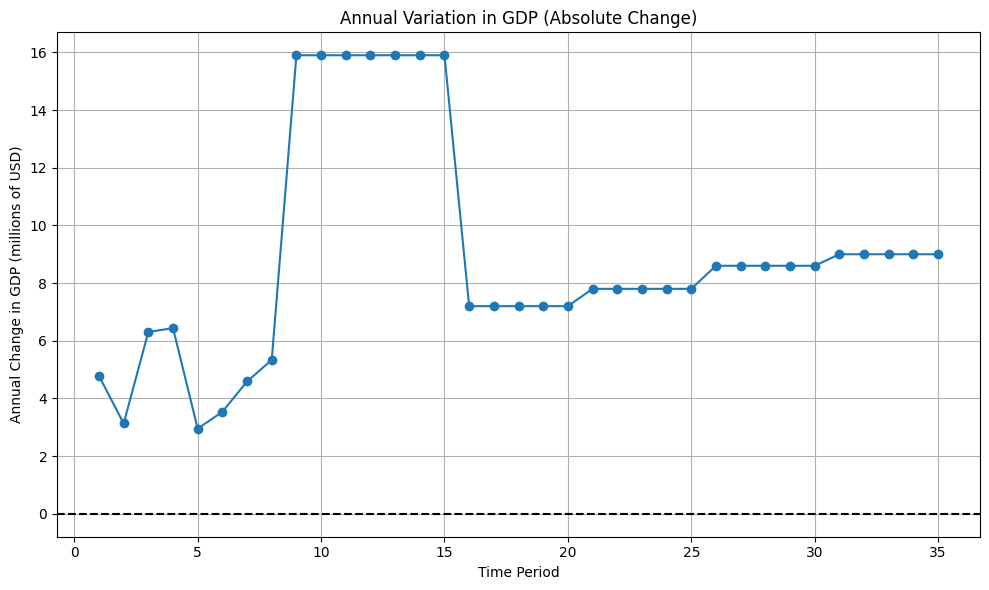

In [39]:
plt.figure(figsize=(10,6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd_pct_change"], marker='o', linestyle='-')

plt.xlabel("Time Period")
plt.ylabel("Annual Change in GDP (millions of USD)")
plt.title("Annual Variation in GDP (Absolute Change)")
plt.axhline(0, color='black', linestyle='--')  # Línea base
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

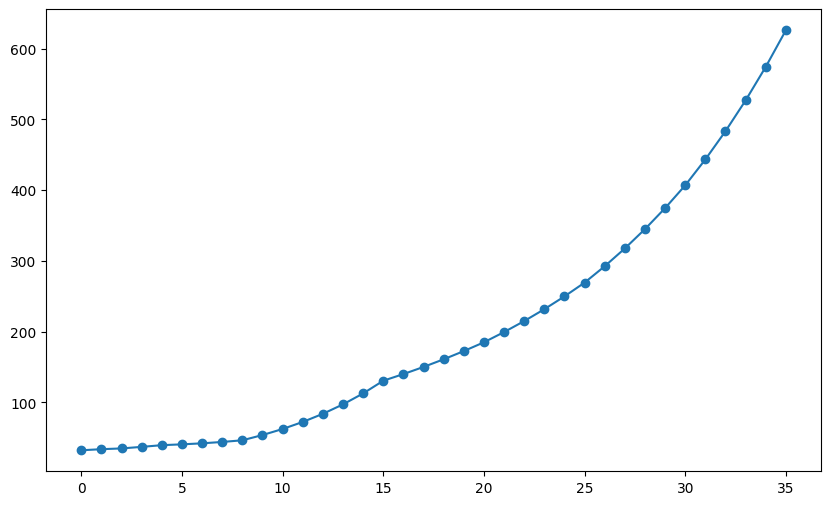

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd"], marker='o')
plt.show()

In [41]:
pop_lvst_initial =  df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "pop_lvst_initial" in i]].columns
pop_lvst_initial 

pop_lvst_initial

Index(['pop_lvst_initial_chickens', 'pop_lvst_initial_goats',
       'pop_lvst_initial_cattle_nondairy', 'pop_lvst_initial_horses',
       'pop_lvst_initial_mules', 'pop_lvst_initial_cattle_dairy',
       'pop_lvst_initial_sheep', 'pop_lvst_initial_pigs',
       'pop_lvst_initial_buffalo'],
      dtype='object')

In [42]:
df_inputs_raw_complete[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,33246,14272733,14031000,0,0,14031000,1918651,2461661,0
1,33941,15806305,14368000,0,0,14368000,2066324,2479272,0
2,35041,16235658,14189000,0,0,14189000,2116855,2501459,0
3,34137,16491153,14572000,0,0,14572000,2154474,2526885,0
4,34942,15920638,14785000,0,0,14785000,2086461,2516546,0


In [43]:
tony = pd.read_csv(os.path.join(dir_data, "UGA_real_data_20250429.csv"))
tony[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,46039000.0,15312000.0,14031000.0,0.0,19220.0,14031000.0,3842000.0,3916000.0,0.0
1,46291000.0,15725000.0,14368000.0,0.0,19247.0,14368000.0,4198000.0,4037000.0,0.0
2,47578000.0,16034000.0,14189000.0,0.0,19277.0,14189000.0,4445000.0,4109000.0,0.0
3,48901000.0,16419000.0,14572000.0,0.0,19310.0,14572000.0,4584000.0,4245000.0,0.0
4,43121000.0,16945000.0,14785000.0,0.0,19343.0,14785000.0,4666000.0,4411000.0,0.0


In [44]:
df_inputs_raw_complete[pop_lvst_initial] = tony[pop_lvst_initial]

In [45]:
df_inputs_raw_complete[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,46039000.0,15312000.0,14031000.0,0.0,19220.0,14031000.0,3842000.0,3916000.0,0.0
1,46291000.0,15725000.0,14368000.0,0.0,19247.0,14368000.0,4198000.0,4037000.0,0.0
2,47578000.0,16034000.0,14189000.0,0.0,19277.0,14189000.0,4445000.0,4109000.0,0.0
3,48901000.0,16419000.0,14572000.0,0.0,19310.0,14572000.0,4584000.0,4245000.0,0.0
4,43121000.0,16945000.0,14785000.0,0.0,19343.0,14785000.0,4666000.0,4411000.0,0.0


## Modify Transportation Demand Elasticities

In [46]:
modvar_passenger = matt.get_variable("Elasticity of Passenger-Kilometer Demand per Capita to GDP per Capita")
modvar_freight = matt.get_variable("Elasticity of Megatonne-Kilometer Demand to GDP")
print(modvar_passenger.fields)
print(modvar_freight.fields)

['elasticity_trde_pkm_to_gdppc_private_and_public', 'elasticity_trde_pkm_to_gdppc_regional']
['elasticity_trde_mtkm_to_gdp_freight']


In [47]:
def modify_input_with_ramp(modvar, df_inputs, target_val, r_0=5):
    arr_elasticities = matt.extract_model_variable(
        df_inputs,
        modvar,
        return_type = "array_base"
    )

    print("Variables Array Shape: ", arr_elasticities.shape)

    vec_ramp = sf.ramp_vector(
        df_inputs.shape[0],
        r_0 = r_0,
    )

    print("Scaling Ramp Vector Shape: ", vec_ramp.shape)

    
    arr_new = (
        arr_elasticities.transpose() * (1 - vec_ramp) + vec_ramp * target_val
    ).transpose()

    

    # if arr_new is a 1D array, convert it to a 2D array with one column
    if arr_new.ndim == 1:
        arr_new = arr_new.reshape(-1, 1)

    print("Final Variables Array Shape: ", arr_new.shape)
    
    return arr_new

def print_df_head_and_tail(df, columns):
    print("Head:")
    print(df[columns].head())
    print("\nTail:")
    print(df[columns].tail())

In [48]:
print_df_head_and_tail(df_inputs_raw_complete, modvar_passenger.fields)

Head:
   elasticity_trde_pkm_to_gdppc_private_and_public  \
0                                             1.12   
1                                             1.12   
2                                             1.12   
3                                             1.12   
4                                             1.12   

   elasticity_trde_pkm_to_gdppc_regional  
0                                   2.64  
1                                   2.64  
2                                   2.64  
3                                   2.64  
4                                   2.64  

Tail:
    elasticity_trde_pkm_to_gdppc_private_and_public  \
31                                             1.12   
32                                             1.12   
33                                             1.12   
34                                             1.12   
35                                             1.12   

    elasticity_trde_pkm_to_gdppc_regional  
31                           

In [49]:
df_inputs_raw_complete[modvar_passenger.fields] = modify_input_with_ramp(modvar_passenger, df_inputs_raw_complete, 1.5)
print_df_head_and_tail(df_inputs_raw_complete, modvar_passenger.fields)

Variables Array Shape:  (36, 2)
Scaling Ramp Vector Shape:  (36,)
Final Variables Array Shape:  (36, 2)
Head:
   elasticity_trde_pkm_to_gdppc_private_and_public  \
0                                             1.12   
1                                             1.12   
2                                             1.12   
3                                             1.12   
4                                             1.12   

   elasticity_trde_pkm_to_gdppc_regional  
0                                   2.64  
1                                   2.64  
2                                   2.64  
3                                   2.64  
4                                   2.64  

Tail:
    elasticity_trde_pkm_to_gdppc_private_and_public  \
31                                         1.449333   
32                                         1.462000   
33                                         1.474667   
34                                         1.487333   
35                       

In [50]:
print_df_head_and_tail(df_inputs_raw_complete, modvar_freight.fields)

Head:
   elasticity_trde_mtkm_to_gdp_freight
0                                    1
1                                    1
2                                    1
3                                    1
4                                    1

Tail:
    elasticity_trde_mtkm_to_gdp_freight
31                                    1
32                                    1
33                                    1
34                                    1
35                                    1


In [51]:
df_inputs_raw_complete[modvar_freight.fields] = modify_input_with_ramp(modvar_freight, df_inputs_raw_complete, 1.0)
print_df_head_and_tail(df_inputs_raw_complete, modvar_freight.fields)
 


Variables Array Shape:  (36,)
Scaling Ramp Vector Shape:  (36,)
Final Variables Array Shape:  (36, 1)
Head:
   elasticity_trde_mtkm_to_gdp_freight
0                                  1.0
1                                  1.0
2                                  1.0
3                                  1.0
4                                  1.0

Tail:
    elasticity_trde_mtkm_to_gdp_freight
31                                  1.0
32                                  1.0
33                                  1.0
34                                  1.0
35                                  1.0


# Fracs SCOE, INEN, TRNS modification

In [52]:
fracs = pd.read_csv(os.path.join(dir_data, "frac_trns_scoe_inen_uganda.csv"))
fracs.head()

,year,iso_alpha_3,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_electricity,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_natural_gas,...,frac_trns_fuelmix_road_light_diesel,frac_trns_fuelmix_road_light_electricity,frac_trns_fuelmix_road_light_gasoline,frac_trns_fuelmix_road_light_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_light_hydrogen,frac_trns_fuelmix_water_borne_ammonia,frac_trns_fuelmix_water_borne_diesel,frac_trns_fuelmix_water_borne_electricity,frac_trns_fuelmix_water_borne_hydrogen,frac_trns_fuelmix_water_borne_natural_gas
0,2000,UGA,0.0,0.000851,0.003991,0.000851,0.000213,0.0,0.000213,0.0,...,0.0,0.0,0.525,0.475,0.0,0.0,1.0,0.0,0.0,0.0
1,2001,UGA,0.0,0.000761,0.003911,0.000761,0.000190,0.0,0.000190,0.0,...,0.0,0.0,0.525,0.475,0.0,0.0,1.0,0.0,0.0,0.0
2,2002,UGA,0.0,0.001682,0.004117,0.001682,0.000421,0.0,0.000421,0.0,...,0.0,0.0,0.525,0.475,0.0,0.0,1.0,0.0,0.0,0.0
3,2003,UGA,0.0,0.001724,0.004231,0.001724,0.000431,0.0,0.000431,0.0,...,0.0,0.0,0.525,0.475,0.0,0.0,1.0,0.0,0.0,0.0
4,2004,UGA,0.0,0.001694,0.004409,0.001694,0.000424,0.0,0.000424,0.0,...,0.0,0.0,0.525,0.475,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
scoe= [col for col in df_inputs_raw_complete.columns if col.startswith("frac_scoe_")]
inen= [col for col in df_inputs_raw_complete.columns if col.startswith("frac_inen_energy_")]
trns= [col for col in df_inputs_raw_complete.columns if col.startswith("frac_trns_fuelmix_")]

In [54]:
df_inputs_raw_complete[scoe].head()

,frac_scoe_heat_energy_other_se_gasoline,frac_scoe_heat_energy_commercial_municipal_hydrogen,frac_scoe_heat_energy_other_se_solid_biomass,frac_scoe_heat_energy_commercial_municipal_kerosene,frac_scoe_heat_energy_other_se_diesel,frac_scoe_heat_energy_residential_electricity,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_other_se_natural_gas,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_kerosene,...,frac_scoe_heat_energy_commercial_municipal_electricity,frac_scoe_heat_energy_other_se_coal,frac_scoe_heat_energy_commercial_municipal_solid_biomass,frac_scoe_heat_energy_other_se_electricity,frac_scoe_heat_energy_other_se_hydrogen,frac_scoe_heat_energy_commercial_municipal_diesel,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_commercial_municipal_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_other_se_kerosene
0,0.010976,0,0.097655,0.011444,0.087809,0.034944,0.097655,0.233652,0.01348,0.010976,...,0.069927,0.010507,0.021416,0.034944,0,0.091554,0.010976,0.009243,0,0.010976
1,0.010976,0,0.097655,0.011444,0.087809,0.034944,0.097655,0.233652,0.01348,0.010976,...,0.069927,0.010507,0.021416,0.034944,0,0.091554,0.010976,0.009243,0,0.010976
2,0.010976,0,0.097655,0.011444,0.087809,0.034944,0.097655,0.233652,0.01348,0.010976,...,0.069927,0.010507,0.021416,0.034944,0,0.091554,0.010976,0.009243,0,0.010976
3,0.010976,0,0.097655,0.011444,0.087809,0.034944,0.097655,0.233652,0.01348,0.010976,...,0.069927,0.010507,0.021416,0.034944,0,0.091554,0.010976,0.009243,0,0.010976
4,0.010976,0,0.097655,0.011444,0.087809,0.034944,0.097655,0.233652,0.01348,0.010976,...,0.069927,0.010507,0.021416,0.034944,0,0.091554,0.010976,0.009243,0,0.010976


In [ ]:
df_inputs_raw_complete[scoe] = fracs[scoe]

In [56]:
df_inputs_raw_complete[scoe].head()

,frac_scoe_heat_energy_other_se_gasoline,frac_scoe_heat_energy_commercial_municipal_hydrogen,frac_scoe_heat_energy_other_se_solid_biomass,frac_scoe_heat_energy_commercial_municipal_kerosene,frac_scoe_heat_energy_other_se_diesel,frac_scoe_heat_energy_residential_electricity,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_other_se_natural_gas,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_kerosene,...,frac_scoe_heat_energy_commercial_municipal_electricity,frac_scoe_heat_energy_other_se_coal,frac_scoe_heat_energy_commercial_municipal_solid_biomass,frac_scoe_heat_energy_other_se_electricity,frac_scoe_heat_energy_other_se_hydrogen,frac_scoe_heat_energy_commercial_municipal_diesel,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_commercial_municipal_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_other_se_kerosene
0,0.012028,0.0,0.968724,0.002993,0.012028,0.003991,0.993881,0.0,0.000213,0.000213,...,0.008520,0.0,0.965714,0.002857,0.0,0.009978,0.000851,0.002818,0.0,0.002005
1,0.011234,0.0,0.970789,0.002796,0.011234,0.003911,0.994187,0.0,0.000190,0.000190,...,0.007959,0.0,0.967971,0.002668,0.0,0.009321,0.000761,0.002632,0.0,0.001872
2,0.010454,0.0,0.972623,0.002602,0.010454,0.004117,0.991678,0.0,0.000421,0.000421,...,0.007987,0.0,0.969619,0.002678,0.0,0.008672,0.001682,0.002449,0.0,0.001742
3,0.009808,0.0,0.974198,0.002441,0.009808,0.004231,0.991460,0.0,0.000431,0.000431,...,0.007841,0.0,0.971150,0.002629,0.0,0.008136,0.001724,0.002297,0.0,0.001635
4,0.009995,0.0,0.973727,0.002487,0.009995,0.004409,0.991356,0.0,0.000424,0.000424,...,0.007926,0.0,0.970664,0.002657,0.0,0.008291,0.001694,0.002341,0.0,0.001666


In [57]:
df_inputs_raw_complete[inen].head()

,frac_inen_energy_recycled_metals_hydrocarbon_gas_liquids,frac_inen_energy_plastic_furnace_gas,frac_inen_energy_recycled_textiles_oil,frac_inen_energy_chemicals_coal,frac_inen_energy_lime_and_carbonite_coal,frac_inen_energy_recycled_textiles_coal,frac_inen_energy_recycled_rubber_and_leather_coke,frac_inen_energy_recycled_plastic_solid_biomass,frac_inen_energy_plastic_oil,frac_inen_energy_other_product_manufacturing_gasoline,...,frac_inen_energy_mining_kerosene,frac_inen_energy_mining_coke,frac_inen_energy_mining_geothermal,frac_inen_energy_mining_oil,frac_inen_energy_mining_diesel,frac_inen_energy_mining_natural_gas,frac_inen_energy_mining_hydrocarbon_gas_liquids,frac_inen_energy_mining_hydrogen,frac_inen_energy_mining_gasoline,frac_inen_energy_mining_solid_biomass
0,0,0.034428,0.051947,0.033432,0.208886,0.021822,0.002159,0.006749,0.049526,0.030736,...,0,0,0,0,0.085106,0.595745,0,0,0,0
1,0,0.035350,0.051353,0.032050,0.195624,0.018666,0.001963,0.006135,0.050172,0.029431,...,0,0,0,0,0.085106,0.595745,0,0,0,0
2,0,0.033245,0.050195,0.031854,0.193533,0.021816,0.002264,0.006719,0.050439,0.029338,...,0,0,0,0,0.085106,0.595745,0,0,0,0
3,0,0.027822,0.050216,0.032380,0.209049,0.020759,0.001932,0.007970,0.044085,0.028573,...,0,0,0,0,0.085106,0.595745,0,0,0,0
4,0,0.027770,0.051158,0.029756,0.197802,0.020843,0.001891,0.007418,0.051250,0.027796,...,0,0,0,0,0.085106,0.595745,0,0,0,0


In [58]:
df_inputs_raw_complete[inen] = fracs[inen]

In [59]:
df_inputs_raw_complete[inen].head()

,frac_inen_energy_recycled_metals_hydrocarbon_gas_liquids,frac_inen_energy_plastic_furnace_gas,frac_inen_energy_recycled_textiles_oil,frac_inen_energy_chemicals_coal,frac_inen_energy_lime_and_carbonite_coal,frac_inen_energy_recycled_textiles_coal,frac_inen_energy_recycled_rubber_and_leather_coke,frac_inen_energy_recycled_plastic_solid_biomass,frac_inen_energy_plastic_oil,frac_inen_energy_other_product_manufacturing_gasoline,...,frac_inen_energy_mining_kerosene,frac_inen_energy_mining_coke,frac_inen_energy_mining_geothermal,frac_inen_energy_mining_oil,frac_inen_energy_mining_diesel,frac_inen_energy_mining_natural_gas,frac_inen_energy_mining_hydrocarbon_gas_liquids,frac_inen_energy_mining_hydrogen,frac_inen_energy_mining_gasoline,frac_inen_energy_mining_solid_biomass
0,NaN,NaN,NaN,0.037953,NaN,NaN,NaN,NaN,NaN,0.010569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.034917,NaN,NaN,NaN,NaN,NaN,0.009100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.031694,NaN,NaN,NaN,NaN,NaN,0.010744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.029265,NaN,NaN,NaN,NaN,NaN,0.011221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.027488,NaN,NaN,NaN,NaN,NaN,0.011066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_inputs_raw_complete[trns].head()

,frac_trns_fuelmix_road_heavy_regional_electricity,frac_trns_fuelmix_powered_bikes_gasoline,frac_trns_fuelmix_rail_freight_diesel,frac_trns_fuelmix_rail_passenger_hydrogen,frac_trns_fuelmix_road_heavy_regional_natural_gas,frac_trns_fuelmix_road_heavy_freight_hydrogen,frac_trns_fuelmix_aviation_electricity,frac_trns_fuelmix_road_light_biofuels,frac_trns_fuelmix_road_heavy_regional_hydrogen,frac_trns_fuelmix_public_hydrogen,...,frac_trns_fuelmix_water_borne_electricity,frac_trns_fuelmix_rail_freight_electricity,frac_trns_fuelmix_water_borne_natural_gas,frac_trns_fuelmix_road_light_hydrogen,frac_trns_fuelmix_road_heavy_freight_natural_gas,frac_trns_fuelmix_public_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_light_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_heavy_regional_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_heavy_freight_hydrocarbon_gas_liquids,frac_trns_fuelmix_water_borne_ammonia
0,0.010721,0.411103,1,0,0.005693,0,0,0.012548,0,0,...,0,0,0,0,0.005693,0,0,0,0,0.0
1,0.010481,0.419593,1,0,0.005776,0,0,0.012667,0,0,...,0,0,0,0,0.005776,0,0,0,0,0.0
2,0.010246,0.437837,1,0,0.005866,0,0,0.012800,0,0,...,0,0,0,0,0.005866,0,0,0,0,0.0
3,0.010027,0.443860,1,0,0.005962,0,0,0.012946,0,0,...,0,0,0,0,0.005962,0,0,0,0,0.0
4,0.009832,0.451351,1,0,0.006065,0,0,0.013111,0,0,...,0,0,0,0,0.006065,0,0,0,0,0.0


In [61]:
df_inputs_raw_complete[trns] = fracs[trns]

In [62]:
df_inputs_raw_complete[trns].head()

,frac_trns_fuelmix_road_heavy_regional_electricity,frac_trns_fuelmix_powered_bikes_gasoline,frac_trns_fuelmix_rail_freight_diesel,frac_trns_fuelmix_rail_passenger_hydrogen,frac_trns_fuelmix_road_heavy_regional_natural_gas,frac_trns_fuelmix_road_heavy_freight_hydrogen,frac_trns_fuelmix_aviation_electricity,frac_trns_fuelmix_road_light_biofuels,frac_trns_fuelmix_road_heavy_regional_hydrogen,frac_trns_fuelmix_public_hydrogen,...,frac_trns_fuelmix_water_borne_electricity,frac_trns_fuelmix_rail_freight_electricity,frac_trns_fuelmix_water_borne_natural_gas,frac_trns_fuelmix_road_light_hydrogen,frac_trns_fuelmix_road_heavy_freight_natural_gas,frac_trns_fuelmix_public_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_light_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_heavy_regional_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_heavy_freight_hydrocarbon_gas_liquids,frac_trns_fuelmix_water_borne_ammonia
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.475,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.475,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.475,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.475,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.475,0.0,0.0,0.0


#  Let's try building transformations using this


In [63]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [64]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [65]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_bau.xlsx


In [66]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_poultry.yaml already exist for strategy strategy_NDC. Please check it manua

In [67]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NDC',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC',
  'TX:IPPU:DEC_DEMAND_STRATEGY_NDC',
  'TX:IPPU:DEC_HFCS_STRATEGY_NDC',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC',
  'TX:TRDE:DEC_DEMAND_STRATEGY_NDC',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC',
  'TX:TRN

In [68]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NDC', 'strategy_NZ', 'strategy_BAU'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [69]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

#csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')
csv_handler.add_strategy(strategy_group='PFLO', description='S BAU', yaml_file_suffix='BAU')


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ
INFO: Strategy code PFLO:BAU already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:BAU


In [70]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

# Manual modification YAML

## TX:LNDU:DEC_DEFORESTATION

In [71]:

import yaml

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.9999999   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

  

In [72]:

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.996


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [73]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [74]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [75]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [76]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/transformations initialized in 1.27 seconds


In [77]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC,NDC,NDC,TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC|TX:AGRC:INC_...,0
70,6004,PFLO:NZ,NZ,Net Zero,TX:SCOE:DEC_DEMAND_HEAT_STRATEGY_NZ|TX:AGRC:DE...,0
71,6005,PFLO:BAU,BAU,S BAU,TX:LVST:INC_PRODUCTIVITY_STRATEGY_BAU|TX:AGRC:...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [78]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2220)
strat 6003 with output shape (36, 2220)
here = 6003
starting strat 6004 with input shape (36, 2220)
strat 6004 with output shape (36, 2220)
here = 6004
starting strat 6005 with input shape (36, 2220)
strat 6005 with output shape (36, 2220)
here = 6005


0

# Finally, load SISEPUEDE so that we can run it

In [79]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-06-03 16:51:03,156 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-03 16:51:03,158 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-03 16:51:03,159 - INFO - 	Setting export engine to 'csv'.
2025-06-03 16:51:03,161 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-06-03 16:51:03,161 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-06-03 16:51:03,162 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-06-03 16:51:03,163 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-06-03 16:51:03,163 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-06-03 16:51:03,164 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-06-03 16:51:03,164 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1810.4 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-06-03 16:51:46,916 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-06-03 16:51:46,938 - INFO - Successfully initialized SISEPUEDEModels.
2025-06-03 16:51:46,947 - INFO - Table ANALYSIS_METADATA successfully written to /home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/pyth

In [80]:
not(energy_model_flag)

False

In [81]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-06-03 16:51:47,166 - INFO - 
***	STARTING REGION uganda	***

2025-06-03 16:51:50,132 - INFO - Trying run primary_id = 0 in region uganda
2025-06-03 16:51:50,133 - INFO - Running AFOLU model
2025-06-03 16:51:50,320 - INFO - AFOLU model run successfully completed
2025-06-03 16:51:50,321 - INFO - Running CircularEconomy model
2025-06-03 16:51:50,380 - INFO - CircularEconomy model run successfully completed
2025-06-03 16:51:50,381 - INFO - Running IPPU model
2025-06-03 16:51:50,482 - INFO - IPPU model run successfully completed
2025-06-03 16:51:50,483 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-06-03 16:51:50,517 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-06-03 16:51:50,600 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-06-03 16:51:50,601 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2025-03-Jun 16:51:51.142 Opened SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-03-Jun 16:51:51.422 Added NEMO structure to SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-03-Jun 16:52:02.555 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-03 16:52:36,307 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-03 16:52:36,322 - INFO - EnergyProduction model run successfully completed
2025-06-03 16:52:36,323 - INFO - Running Energy (Fugitive Emissions)


2025-03-Jun 16:52:36.134 Finished modeling scenario.


2025-06-03 16:52:36,383 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-06-03 16:52:36,383 - INFO - Appending Socioeconomic outputs
2025-06-03 16:52:36,400 - INFO - Socioeconomic outputs successfully appended.
2025-06-03 16:52:36,403 - INFO - Model run for primary_id = 0 successfully completed in 46.27 seconds (n_tries = 1).
2025-06-03 16:52:36,425 - INFO - Trying run primary_id = 69069 in region uganda
2025-06-03 16:52:36,425 - INFO - Running AFOLU model
2025-06-03 16:52:36,611 - INFO - AFOLU model run successfully completed
2025-06-03 16:52:36,611 - INFO - Running CircularEconomy model
2025-06-03 16:52:36,672 - INFO - CircularEconomy model run successfully completed
2025-06-03 16:52:36,673 - INFO - Running IPPU model
2025-06-03 16:52:36,771 - INFO - IPPU model run successfully completed
2025-06-03 16:52:36,772 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-06-03 16:52:36,808 - DEBUG - Missing elasticity information foun

2025-03-Jun 16:52:38.019 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-03 16:53:35,123 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-03 16:53:35,135 - INFO - EnergyProduction model run successfully completed
2025-06-03 16:53:35,136 - INFO - Running Energy (Fugitive Emissions)


2025-03-Jun 16:53:34.970 Finished modeling scenario.


2025-06-03 16:53:35,196 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-06-03 16:53:35,196 - INFO - Appending Socioeconomic outputs
2025-06-03 16:53:35,217 - INFO - Socioeconomic outputs successfully appended.
2025-06-03 16:53:35,221 - INFO - Model run for primary_id = 69069 successfully completed in 58.8 seconds (n_tries = 1).
2025-06-03 16:53:35,226 - INFO - Trying run primary_id = 70070 in region uganda
2025-06-03 16:53:35,227 - INFO - Running AFOLU model
2025-06-03 16:53:35,407 - INFO - AFOLU model run successfully completed
2025-06-03 16:53:35,408 - INFO - Running CircularEconomy model
2025-06-03 16:53:35,498 - INFO - CircularEconomy model run successfully completed
2025-06-03 16:53:35,499 - INFO - Running IPPU model
2025-06-03 16:53:35,635 - INFO - IPPU model run successfully completed
2025-06-03 16:53:35,636 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-06-03 16:53:35,673 - DEBUG - Missing elasticity information f

2025-03-Jun 16:53:37.012 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-03 16:54:30,525 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-03 16:54:30,538 - INFO - EnergyProduction model run successfully completed
2025-06-03 16:54:30,539 - INFO - Running Energy (Fugitive Emissions)


2025-03-Jun 16:54:30.363 Finished modeling scenario.


2025-06-03 16:54:30,602 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-06-03 16:54:30,603 - INFO - Appending Socioeconomic outputs
2025-06-03 16:54:30,621 - INFO - Socioeconomic outputs successfully appended.
2025-06-03 16:54:30,624 - INFO - Model run for primary_id = 70070 successfully completed in 55.4 seconds (n_tries = 1).
2025-06-03 16:54:30,629 - INFO - Trying run primary_id = 71071 in region uganda
2025-06-03 16:54:30,629 - INFO - Running AFOLU model
2025-06-03 16:54:30,808 - INFO - AFOLU model run successfully completed
2025-06-03 16:54:30,809 - INFO - Running CircularEconomy model
2025-06-03 16:54:30,868 - INFO - CircularEconomy model run successfully completed
2025-06-03 16:54:30,869 - INFO - Running IPPU model
2025-06-03 16:54:29,349 - INFO - IPPU model run successfully completed
2025-06-03 16:54:29,350 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-06-03 16:54:29,384 - DEBUG - Missing elasticity information f

2025-03-Jun 16:54:30.670 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-03 16:54:52,905 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-03 16:54:52,917 - INFO - EnergyProduction model run successfully completed
2025-06-03 16:54:52,917 - INFO - Running Energy (Fugitive Emissions)


2025-03-Jun 16:54:52.760 Finished modeling scenario.


2025-06-03 16:54:52,981 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-06-03 16:54:52,982 - INFO - Appending Socioeconomic outputs
2025-06-03 16:54:53,006 - INFO - Socioeconomic outputs successfully appended.
2025-06-03 16:54:53,010 - INFO - Model run for primary_id = 71071 successfully completed in 22.38 seconds (n_tries = 1).
2025-06-03 16:54:53,013 - INFO - 
***	 REGION uganda COMPLETE	***

2025-06-03 16:54:53,112 - INFO - Table MODEL_OUTPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-06-03T16;51;02.644585/sisepuede_run_2025-06-03T16;51;02.644585_output_database/MODEL_OUTPUT.csv.
2025-06-03 16:54:53,115 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-06-03T16;51;02.644585/sisepuede_run_2025-06-03T16;51;02.644585_output_database/ATTRIBUTE_PRIMARY.csv

{'uganda': [0, 69069, 70070, 71071]}

In [82]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [83]:
matt.get_all_subsector_emission_total_fields()

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ccsq',
 'emission_co2e_subsector_total_entc',
 'emission_co2e_subsector_total_fgtv',
 'emission_co2e_subsector_total_inen',
 'emission_co2e_subsector_total_scoe',
 'emission_co2e_subsector_total_trns',
 'emission_co2e_subsector_total_ippu']

In [84]:
bau_out_df = df_out[df_out['primary_id'] == 71071]
ndc_out_df = df_out[df_out['primary_id'] == 69069]
nz_out_df = df_out[df_out['primary_id'] == 70070]

In [85]:
[col for col in df_in.columns if "ccsq" in col]

['efficfactor_ccsq_heat_energy_direct_air_capture_geothermal',
 'efficfactor_ccsq_heat_energy_direct_air_capture_hydrogen',
 'efficfactor_ccsq_heat_energy_direct_air_capture_natural_gas',
 'energy_intensity_ccsq_direct_air_capture_gj_per_tonne_co2',
 'frac_ccsq_energydem_direct_air_capture_electricity',
 'frac_ccsq_energydem_direct_air_capture_heat',
 'frac_ccsq_heat_energy_direct_air_capture_geothermal',
 'frac_ccsq_heat_energy_direct_air_capture_hydrogen',
 'frac_ccsq_heat_energy_direct_air_capture_natural_gas',
 'qty_ccsq_mt_co2_captured_sequestered_by_direct_air_capture']

## Check Energy outputs

In [86]:
df_in[[col for col in df_in.columns if "elasticity_trde" in col]].head(35)

,elasticity_trde_mtkm_to_gdp_freight,elasticity_trde_pkm_to_gdppc_private_and_public,elasticity_trde_pkm_to_gdppc_regional
0,1.0,1.120000,2.640
1,1.0,1.120000,2.640
2,1.0,1.120000,2.640
3,1.0,1.120000,2.640
4,1.0,1.120000,2.640
5,1.0,1.120000,2.640
6,1.0,1.132667,2.602
7,1.0,1.145333,2.564
8,1.0,1.158000,2.526
9,1.0,1.170667,2.488


In [87]:
def plot_columns(df, time_col, value_cols):
    """
    Plots a line plot for the specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - time_col (str): The column to use for the X-axis (e.g., time_period).
    - value_cols (list of str): The columns to plot as lines.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    for col in value_cols:
        plt.plot(df[time_col], df[col], label=col)
    
    plt.xlabel(time_col)
    plt.ylabel("Values")
    plt.title("Line Plot of Selected Columns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [88]:
electricity_cols = [
    "emission_co2e_subsector_total_trns"
]

In [89]:
bau_out_df[[col for col in bau_out_df.columns if "gdp_mmm" in col or 'population' in col or 'gdp_per_capita' in col]]

,gdp_per_capita_usd,population_gnrl_total
108,847.267626,3.822545e+07
109,855.897173,3.964917e+07
110,850.162195,4.116659e+07
111,870.708737,4.272903e+07
112,894.520364,4.426959e+07
113,891.295901,4.574100e+07
114,900.977642,4.684976e+07
115,915.192067,4.823820e+07
116,937.064121,4.962664e+07
117,1056.498908,5.101508e+07


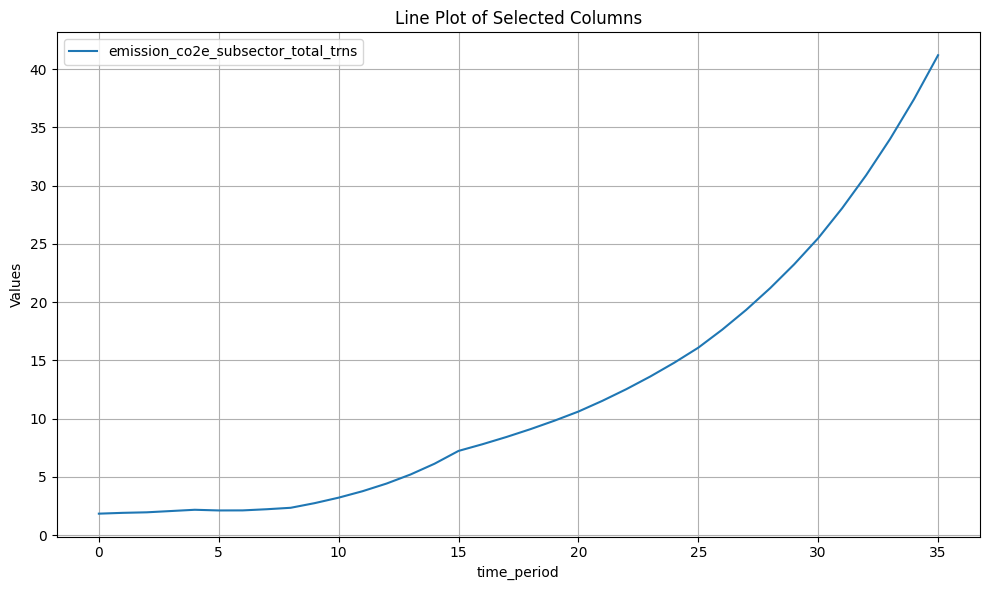

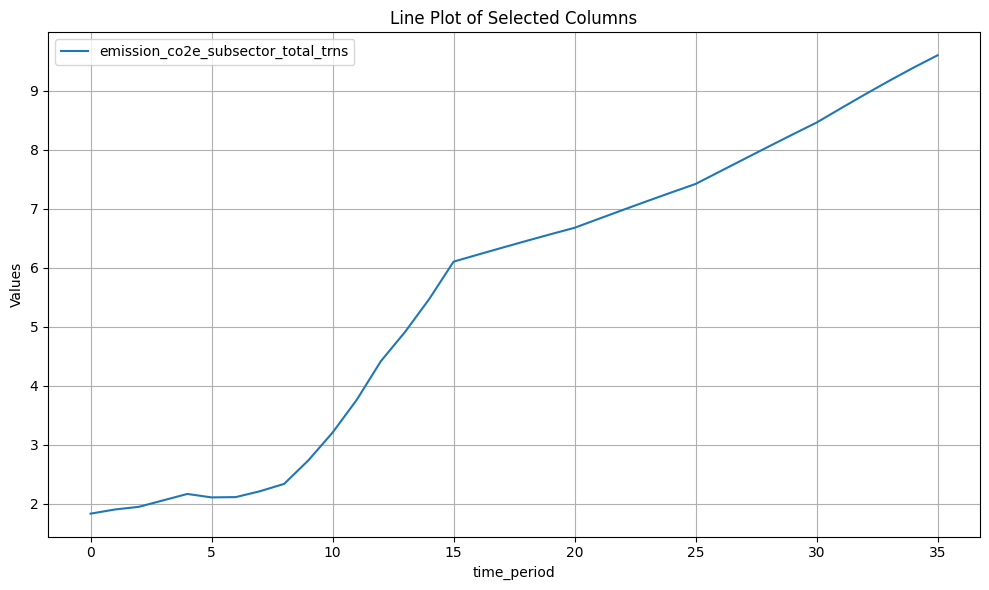

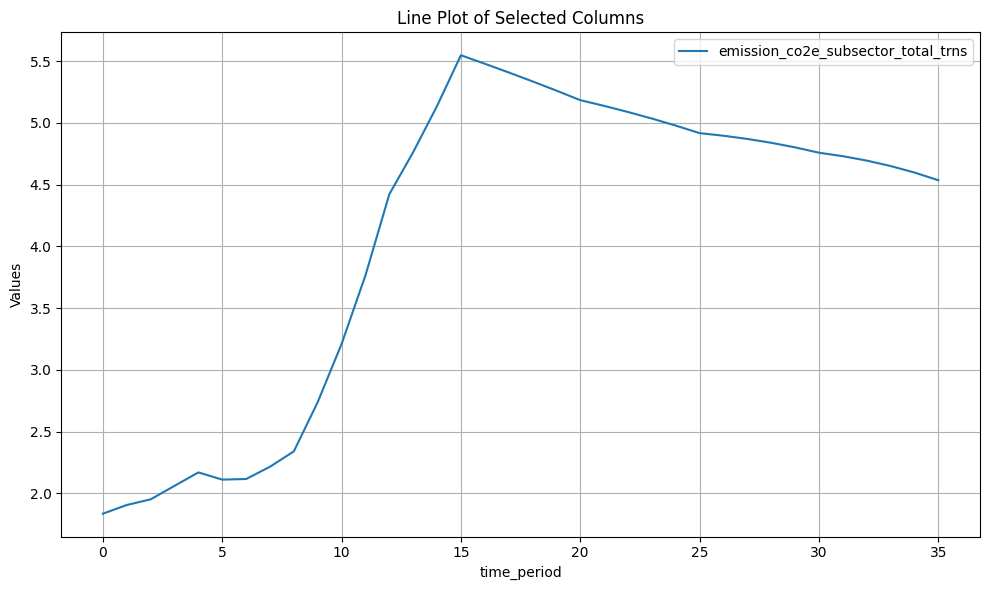

In [90]:
plot_columns(bau_out_df, 'time_period', electricity_cols)
plot_columns(ndc_out_df, 'time_period', electricity_cols)
plot_columns(nz_out_df, 'time_period', electricity_cols)

In [91]:
# entc_output_cols = [col for col in bau_out_df.columns if "emission" in col and "entc" in col and not "subsector_total" in col]

In [92]:
# plot_columns(bau_out_df, 'time_period', entc_output_cols)
# plot_columns(ndc_out_df, 'time_period', entc_output_cols)
# plot_columns(nz_out_df, 'time_period', entc_output_cols)

# Export Wide File (Last Mandatory Step)

In [93]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [94]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'

In [95]:
df_primary.to_csv(
    os.path.join(dir_out, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_out, f"sisepuede_results_sisepuede_bau_run.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_out, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")